In [849]:
#@title
import numpy as np
import torch

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title
!pip3 install torch torchvision

In [235]:
#@title
file = open("/content/drive/MyDrive/AI/spiral/two_spiral_train_data.txt")
lines = file.readlines()
train_set = []
target_set = []
for item in lines:
  nums = item.split()
  train_set.append([float(nums[0]), float(nums[1])])
  target_set.append([float(nums[2])])

file = open("/content/drive/MyDrive/AI/spiral/two_spiral_test_data.txt")
lines = file.readlines()
test_input_set = []
test_target_set = []
for item in lines:
  nums = item.split()
  test_input_set.append([float(nums[0]), float(nums[1])])
  test_target_set.append([float(nums[2])])
  
train_set = np.array(train_set)
target_set = np.array(target_set)
train_set = torch.from_numpy(train_set)
target_set = torch.from_numpy(target_set)
test_input_set = np.array(test_input_set)
test_target_set = np.array(test_target_set)
test_input_set = torch.from_numpy(test_input_set)
test_target_set = torch.from_numpy(test_target_set)

In [850]:
#@title
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class train_dataset(Dataset):
  def __init__(self):
    self.input = train_set
    self.target = target_set

  def __getitem__(self, index):
    return self.input[index], self.target[index]

  def __len__(self):
    return len(self.input)

class test_dataset(Dataset):
  def __getitem__(self, index):
    return test_input_set[index], test_target_set[index]
  def __len__(self):
    return len(test_input_set)

In [859]:
#@title
import pickle

def save_model(fn, Ws, bs):
  with open(fn, 'wb') as f:
    pickle.dump(Ws, f)
    pickle.dump(bs, f)

def read_model(fn, Ws, bs):
  with open(fn, 'rb') as f:
    Ws = pickle.load(f)
    bs = pickle.load(f)

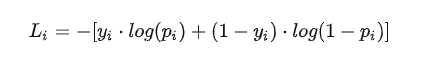

In [860]:
#@title
cur_mean_loss = -1

def hardlim(n):
  if n[0] > 0:
    n[0] = 1
  else:
    n[0] = 0
  return n

def cross_entropy(a_hat, t):
  return -torch.log(a_hat[range(len(a_hat)), t.long()])

def forward(X, Ws, bs):
  n = torch.zeros(1)
  a = X.unsqueeze(-1)
  for W, b in zip(Ws, bs):
    n = torch.matmul(W, a) + b.unsqueeze(-1)
    a = torch.relu(n)

  a = torch.sigmoid(n)
  return a.squeeze(-1)

def backward(F, alpha, Ws, bs):
  global W1, b1, W2, b2
  g = torch.autograd.grad(outputs=F, inputs=Ws+bs)

  for i in range(len(Ws)):
    Ws[i] = Ws[i] - g[i].mul(alpha)

  for i in range(len(bs)):
    bs[i] = bs[i] - g[i+len(Ws)].mul(alpha)

def train_epoch(alpha, iter, Ws, bs):
  global cur_mean_loss
  global runs
  a_ret = torch.tensor(1)
  for bid, (X, T) in enumerate(iter):
    runs+=1

    A = forward(X, Ws, bs)
    A_hat = torch.cat((A, torch.ones_like(A) - A), dim=1)[:, [1, 0]]

    a = A_hat

    E = cross_entropy(A_hat, T.squeeze(-1)).mean()
    cur_mean_loss = E.item()
    backward(E, alpha, Ws, bs)
  return a_ret

def train_till_loss(max_epoch, alpha, dataloader, target, Ws, bs):
  #train
  x_epoch = []
  y_loss = []
  i = 0
  while((cur_mean_loss == -1 or cur_mean_loss > target) and i < max_epoch):
    i+=1
    data_iter = iter(dataloader)
    a = train_epoch(alpha, data_iter, Ws, bs)
    if(i%100 == 0):
      print("finished epoch "+ str(i))
      print("current loss: "+ str(cur_mean_loss))
      x_epoch.append(i)
      y_loss.append(cur_mean_loss)
  
  return x_epoch, y_loss

def train(epoch, alpha, dataloader, Ws, bs):
  #train
  x_epoch = []
  y_loss = []

  for i in range(epoch):
    data_iter = iter(dataloader)
    a = train_epoch(alpha, data_iter, Ws, bs)
    if(i%100 == 0):
      print("finished epoch "+ str(i))
      print("current loss: "+ str(cur_mean_loss))
      x_epoch.append(i)
      y_loss.append(cur_mean_loss)
  
  return x_epoch, y_loss

def test(dataloader, Ws, bs):
  #test
  hit = 0.0
  sum = 0.0
  data_iter = iter(dataloader)
  index = []
  for X, T in data_iter:
    A = forward(X, Ws, bs)
    A = A-torch.ones_like(A)*0.5
    
    equals = torch.eq(torch.clamp(torch.sign(A),min=0), T)
    # print(equals)
    # for i, e in enumerate(T):
    #   if T[i].item()==0:
    #     index.append(i)
    #   else:
    #     print(torch.sign(A)[i].item(), T[i].item())
      
    hit += equals.sum().item()
    sum += T.numel()
  
  return hit, sum

In [870]:
#@title
from torch import nn

def init_train(num_hiddens):
  global cur_mean_loss
  cur_mean_loss = -1
  train_data = train_dataset()
  test_data = test_dataset()
  train_loader = DataLoader(train_data, batch_size=300, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=300, shuffle=True)
  Ws, bs = init_model(num_hiddens)
  return train_loader, test_loader, Ws, bs

In [862]:
#@title
import torch
import math
def init_model(num_hiddens):
  num_inputs, num_outputs = 2, 1

  torch.manual_seed(torch.seed())
  W0 = torch.randn(num_hiddens[0], num_inputs, requires_grad=True).double() * np.sqrt(2.0/(num_inputs))
  b0 = torch.zeros(num_hiddens[0], requires_grad=True).double()

  Wh = []
  bh = []

  for i in range(len(num_hiddens)-1):
    Wh.append(torch.randn(num_hiddens[i+1], num_hiddens[i], requires_grad=True).double() * np.sqrt(2.0 / (num_hiddens[i])))
    bh.append(torch.zeros(num_hiddens[i+1], requires_grad=True).double())

  W1 = torch.randn(num_outputs, num_hiddens[len(num_hiddens)-1], requires_grad=True).double() * np.sqrt(2.0/(num_hiddens[-1]))
  b1 = torch.zeros(num_outputs, requires_grad=True).double()

  Ws = [W0] + Wh + [W1]
  bs = [b0] + bh + [b1]

  return Ws, bs

In [863]:
#@title
import numpy as np
import sklearn
import matplotlib.pyplot as plt
def draw_border(Ws, bs):
  plt.figure(figsize=(8,8))
  fig, (ax1) = plt.subplots(1, figsize=(8,8))

  x = np.arange(-7, 7, 0.1)
  y = np.arange(-7, 7, 0.1)
  xx, yy = np.meshgrid(x, y)  # 生成网格点的横坐标xx与纵坐标yy

  pts = torch.stack((torch.from_numpy(xx).flatten(),
                  torch.from_numpy(yy).flatten()), dim=1)

  z = forward(pts, Ws, bs).reshape(len(x), len(y)).detach().numpy()  # 三维中的高度值
  ax1.contourf(xx, yy, z) #不同高度面填充颜色

  tx = test_input_set.numpy()[:, 0]
  ty = test_input_set.numpy()[:, 1]

  index = []
  for i in range(len(tx)):
    if(test_target_set.numpy()[i] == 1):
      index.append(i)

  tx_pass = tx[[index]]
  ty_pass = ty[[index]]
  fail_index = [item for item in range(len(tx)) if item not in index]
  tx_fail = tx[[fail_index]]
  ty_fail = ty[[fail_index]]
  ax1.scatter(tx_pass, ty_pass, c='skyblue')
  ax1.scatter(tx_fail, ty_fail, c='red')
  plt.show()

def draw_loss(x_epoch, y_loss):
  l1=plt.plot(x_epoch,y_loss,'r--',label='loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

训练：

In [ ]:
train_loader, test_loader, Ws, bs = init_train([16, 32, 16])
x_epoch, y_loss = train_till_loss(10000, 0.001, train_loader, 0.1, Ws, bs)
draw_border(Ws, bs)
draw_loss(x_epoch, y_loss)

绘制边界与损失曲线：

In [ ]:
draw_border(Ws, bs)
draw_loss(x_epoch, y_loss)

测试：

In [879]:
hit, sum = test(test_loader, Ws, bs)
print("accuracy: "+str(hit/sum))

accuracy: 0.48333333333333334


保存模型

In [873]:
save_model("/content/drive/MyDrive/AI/spiral/model_[16,32,16]a=0.01.pkl", Ws, bs)

In [ ]:
#@title
#test

torch.manual_seed(torch.seed())
print(torch.randn(num_inputs))
forward(torch.randn(num_inputs).double())

In [ ]:
#@title
#test
W = torch.tensor([[1, 1], [1, 1], [1, 1]])
M = torch.tensor([[1., 1.], [2., 2.], [3., 3.]]).double()
b = torch.tensor([1, 1, 1])
A = forward(M)

T = torch.tensor([[1], [0], [1]])

A_hat = torch.cat((A, torch.ones_like(A) - A), dim=1)[:, [1, 0]]
print(A_hat)
print(T.squeeze(-1))
cross_entropy(A_hat, T.squeeze(-1)).mean()